<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/4.%20TFIM%20NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

In [3]:
seed_list = [1,   4,   5,   6,   7,   8,  10,  11,  12,  13,
14,  15,  17,  18,  19,  20,  21,  23,  24,  25,
27,  28,  29,  30,  31,  34,  36,  38,  39,  40,
41,  42,  43,  45,  46,  47,  48,  49,  51,  52,
55,  59,  61,  63,  65,  66,  67,  68,  70,  71,
74,  75,  76,  77,  78,  81,  86,  87,  90,  93,
95,  96,  97,  101, 102, 103, 104, 105, 106, 107,
112, 113, 114, 116, 118, 121, 124, 126, 127, 128,
132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
144, 147, 148, 149, 150, 151, 152, 154, 155, 162,
165, 166, 169, 171, 172, 174]

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [26]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [27]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

In [28]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# NN in Noiseless Simulator


1. Only Apply Hadamard Gate for (P)QC

2. Measure each probability of bitstring and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [29]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

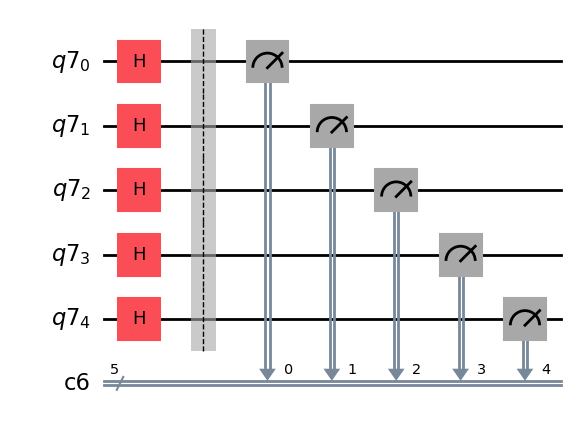

In [30]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

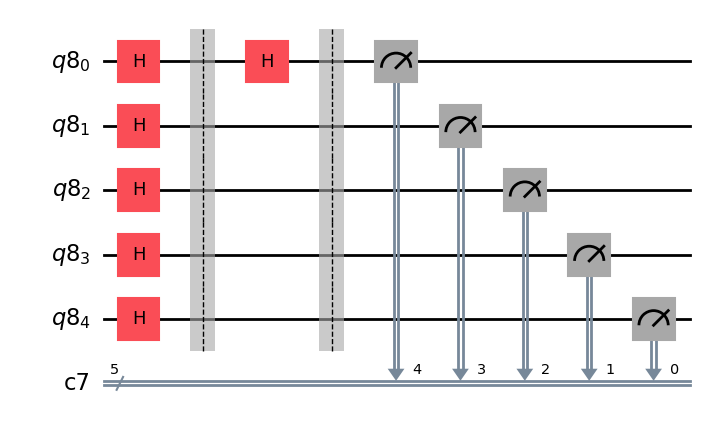

In [31]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

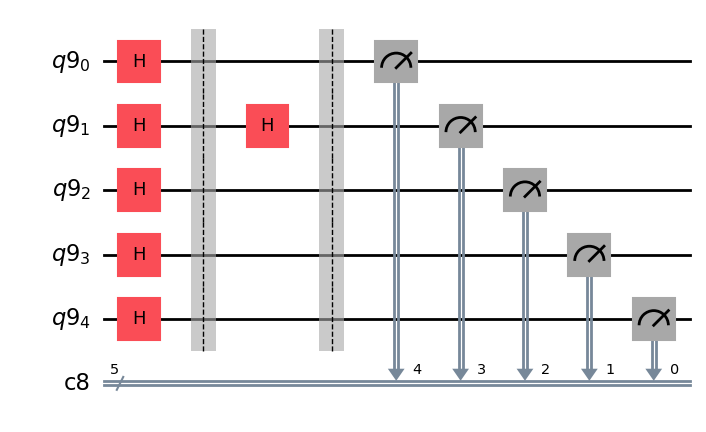

In [32]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

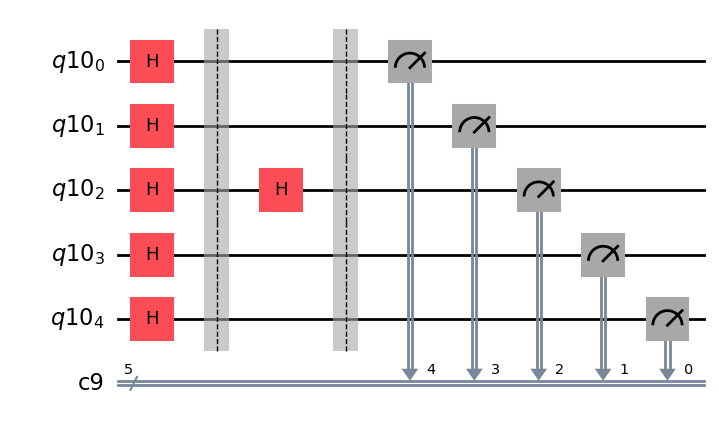

In [33]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

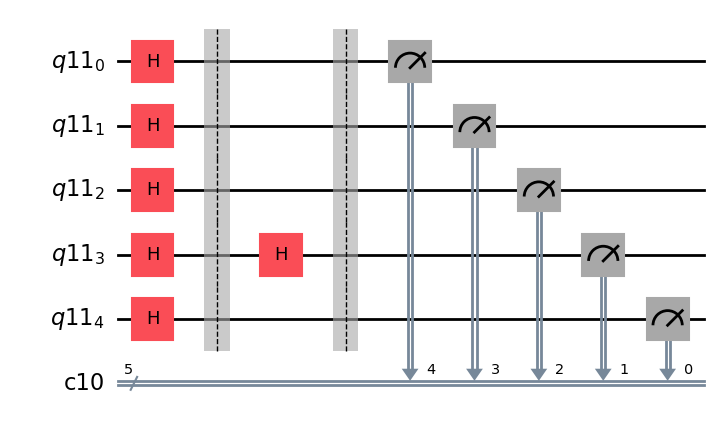

In [34]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

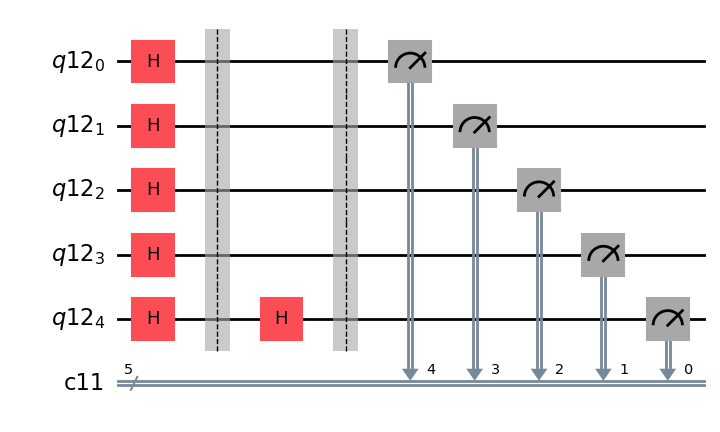

In [35]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [36]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## Cost Function for VQNHE

In [37]:
prob_string_zz = {0: 0.03125, 1: 0.03125, 2: 0.03125, 3: 0.03125, 4: 0.03125, 5: 0.03125, 6: 0.03125, 7: 0.03125, 8: 0.03125, 9: 0.03125, 10: 0.03125, 11: 0.03125, 12: 0.03125, 13: 0.03125, 14: 0.03125, 15: 0.03125, 16: 0.03125, 17: 0.03125, 18: 0.03125, 19: 0.03125, 20: 0.03125, 21: 0.03125, 22: 0.03125, 23: 0.03125, 24: 0.03125, 25: 0.03125, 26: 0.03125, 27: 0.03125, 28: 0.03125, 29: 0.03125, 30: 0.03125, 31: 0.03125}
prob_string_x0 = {0: 0.0625, 1: 0.0625, 2: 0.0625, 3: 0.0625, 4: 0.0625, 5: 0.0625, 6: 0.0625, 7: 0.0625, 8: 0.0625, 9: 0.0625, 10: 0.0625, 11: 0.0625, 12: 0.0625, 13: 0.0625, 14: 0.0625, 15: 0.0625, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x1 = {0: 0.0625, 1: 0.0625, 2: 0.0625, 3: 0.0625, 4: 0.0625, 5: 0.0625, 6: 0.0625, 7: 0.0625, 16: 0.0625, 17: 0.0625, 18: 0.0625, 19: 0.0625, 20: 0.0625, 21: 0.0625, 22: 0.0625, 23: 0.0625, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x2 = {0: 0.0625, 1: 0.0625, 2: 0.0625, 3: 0.0625, 8: 0.0625, 9: 0.0625, 10: 0.0625, 11: 0.0625, 16: 0.0625, 17: 0.0625, 18: 0.0625, 19: 0.0625, 24: 0.0625, 25: 0.0625, 26: 0.0625, 27: 0.0625, 4: 0, 5: 0, 6: 0, 7: 0, 12: 0, 13: 0, 14: 0, 15: 0, 20: 0, 21: 0, 22: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x3 = {0: 0.0625, 1: 0.0625, 4: 0.0625, 5: 0.0625, 8: 0.0625, 9: 0.0625, 12: 0.0625, 13: 0.0625, 16: 0.0625, 17: 0.0625, 20: 0.0625, 21: 0.0625, 24: 0.0625, 25: 0.0625, 28: 0.0625, 29: 0.0625, 2: 0, 3: 0, 6: 0, 7: 0, 10: 0, 11: 0, 14: 0, 15: 0, 18: 0, 19: 0, 22: 0, 23: 0, 26: 0, 27: 0, 30: 0, 31: 0}
prob_string_x4 = {0: 0.0625, 2: 0.0625, 4: 0.0625, 6: 0.0625, 8: 0.0625, 10: 0.0625, 12: 0.0625, 14: 0.0625, 16: 0.0625, 18: 0.0625, 20: 0.0625, 22: 0.0625, 24: 0.0625, 26: 0.0625, 28: 0.0625, 30: 0.0625, 1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0, 15: 0, 17: 0, 19: 0, 21: 0, 23: 0, 25: 0, 27: 0, 29: 0, 31: 0}

In [38]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [39]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [40]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [41]:
def Z0Z1(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [42]:
def X0(params_nn):
  prob_string = prob_string_x0
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn):
  prob_string = prob_string_x1
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn):
  prob_string = prob_string_x2
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn):
  prob_string = prob_string_x3
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn):
  prob_string = prob_string_x4
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [43]:
def norm(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [44]:
def cost_func_vqnhe(params_nn):
  expval = 0
  expval = expval + Z0Z1(params_nn)
  expval = expval + Z1Z2(params_nn)
  expval = expval + Z2Z3(params_nn)
  expval = expval + Z3Z4(params_nn)

  expval = expval - X0(params_nn)
  expval = expval - X1(params_nn)
  expval = expval - X2(params_nn)
  expval = expval - X3(params_nn)
  expval = expval - X4(params_nn)

  expval = expval / norm(params_nn)

  return expval

In [45]:
def build_callback_vqnhe(callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Repeat Optimizing Parameters in NN for 10 times

np.random.seed(k)

k 0~100

In [ ]:
local_minimum_list = []

for k in range(10):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(callback_dict)

  options = dict()
  options["maxiter"] = 1000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
## NN optimized parameter

op_param_nn = np.array([-6.39460622e-01, -9.61049517e-01, -3.44339135e-01, -1.82542009e-01,
       -4.69011457e-01, -4.35652353e-01, -8.01625035e-02, -1.47581304e-01,
        7.81651244e-01,  7.72153254e-01,  5.81877989e-01, -1.90542966e+00,
        1.33083070e+00,  1.01419829e-01, -4.42492658e-01,  3.53054798e-01,
       -9.59032774e-01, -7.66525462e-01, -5.01730326e-01, -6.84175387e-01,
       -6.08245411e-02,  6.61688334e-01, -2.45080155e-02, -7.97063714e-01,
       -9.22568555e-01, -8.32093713e-01, -4.15146201e-01,  3.09734372e-01,
       -8.88652641e-01, -1.89271086e-01, -4.62710471e-01,  8.08237257e-01,
        2.43848089e-01,  2.15808499e-01, -5.51193529e-01,  3.50405297e-01,
        1.30095768e+00, -4.42047635e-01, -8.01557057e-01,  1.20224764e+00,
       -8.72627138e-01, -2.70768714e-01, -8.59954395e-01, -3.61264586e-01,
       -8.59234810e-01, -2.27578343e-01,  1.02157423e-01,  1.06782224e+00,
        1.98235220e-01, -1.30121773e-02,  2.32036770e-01, -9.89904742e-02,
       -1.07222359e+00, -1.13816697e-01,  4.85603794e-01, -8.01152920e-01,
       -3.54510957e-01,  6.95447285e-01, -4.00095981e-01,  6.51060665e-01,
        5.06932396e-01,  8.14243112e-01, -2.43924231e-01, -2.64644336e-01,
        6.82391136e-01,  4.50670366e-01,  2.07058331e-01,  4.70551571e-01,
        2.84429717e-01,  8.50043064e-01, -4.08719872e-01,  3.79627747e-01,
        1.17438400e+00, -2.98493824e-01,  2.49188893e-02, -2.01159591e-01,
       -3.39767422e-01, -8.39056242e-01, -9.61313275e-01,  1.84313790e-01,
       -1.02182795e-01,  3.15277649e-01,  4.72268301e-01, -1.58147649e-01,
       -3.01364430e-01, -6.23169550e-01,  6.23607573e-01,  6.29746369e-01,
        4.68425975e-01,  7.50369650e-01,  3.76948665e-01, -1.42262230e-01,
       -9.33810640e-01,  5.22035772e-01, -5.25264052e-01, -3.12419973e-01,
       -1.85514432e-01,  2.87569898e-01,  3.17384703e-01,  5.33675795e-01,
       -3.71368953e-01, -6.67174804e-01,  6.43120828e-01, -3.95005237e-01,
       -2.01823318e-01, -8.11402264e-01, -6.67454914e-01, -6.68765489e-01,
       -3.12573386e-01, -2.24313953e-02,  9.46259198e-01,  2.29892767e-01,
       -2.34919179e-01,  2.96668668e-01,  1.76853571e-01,  6.78745531e-01,
       -1.58728217e-01,  8.99571326e-01, -1.68992662e-01, -4.33820514e-01,
       -2.48004619e-02,  8.04415649e-01,  4.61759254e-01, -1.88029557e-02,
       -6.51833345e-02,  3.99367266e-01, -1.91288029e-03,  2.79604319e-01,
        9.42350407e-01,  8.25206814e-01,  6.80561681e-01, -7.57983505e-01,
        1.74827229e-01, -2.68910480e-01,  8.07125234e-01, -3.63347064e-01,
        7.12696226e-01, -7.34541347e-01, -1.59218450e-01,  9.26895100e-01,
        2.25693269e-01,  7.54843871e-01, -9.04674321e-02, -5.63339218e-01,
        4.99968307e-01, -2.01485352e-01, -3.01245675e-01, -1.02177800e+00,
       -7.10161076e-01,  1.15368001e+00,  8.28477955e-01,  7.64913532e-01,
       -3.86225205e-01, -8.98823136e-01,  2.21119867e-01,  5.61932652e-01,
        1.12502908e+00, -8.37215110e-01, -5.34234335e-01, -4.46185897e-03,
       -8.09358583e-01,  6.89300901e-01,  6.59639436e-01, -5.13348447e-01,
       -8.05151098e-01,  8.32565860e-01,  4.97918769e-01, -3.67135583e-01,
       -4.34867195e-02,  8.13233408e-01, -2.76295109e-01, -8.57754078e-01,
        3.89654263e-01, -3.74910481e-01,  3.73169480e-01,  7.88981723e-01,
       -5.59442842e-01, -7.21675349e-01, -8.94096264e-01,  2.96717353e-01,
       -8.38454487e-01,  9.16746888e-01,  4.13893745e-01,  8.11201028e-01,
        6.01129875e-01, -6.12015630e-01, -6.68323692e-01,  9.20070380e-01,
       -4.17924048e-01,  5.67029123e-01, -6.58419704e-01, -1.54022813e-01,
        4.06887809e-01, -5.72715201e-01,  2.95387774e-01,  8.10098921e-01,
       -3.99472142e-01, -6.67432947e-01, -9.44534678e-01, -3.34505803e-01,
       -7.77983883e-01,  1.40930791e-01,  2.34294858e-01,  1.60503194e-01,
        3.38701628e-01,  6.26870945e-02,  7.61063404e-01,  2.53270324e-01,
        7.22785375e-01, -1.16460617e-01, -7.18748229e-01, -6.87994576e-01,
        4.44425542e-01, -5.37891005e-01,  5.88378478e-01,  7.60107790e-01,
        1.01549738e-01, -6.95007577e-01,  2.46993207e-01, -2.76430942e-01,
        8.16895886e-01, -5.74588868e-01, -5.29349472e-01, -3.58613347e-02,
       -1.73821440e-02, -6.24141837e-01, -2.67566824e-01,  3.22337858e-01,
       -5.89599016e-02, -8.87241609e-01, -1.61901062e-01, -4.35465718e-01,
       -3.76278731e-03, -9.89508899e-01, -5.26528384e-01,  1.02733642e+00,
        7.97576230e-01,  9.89823606e-01,  5.17780207e-01,  4.37282833e-02,
        8.75008369e-01, -7.10376976e-01, -4.63965755e-01,  2.56682606e-01,
        1.21318412e-01, -4.64365974e-01, -2.76108570e-01, -5.29278450e-02,
       -4.31956826e-01, -6.06307279e-01, -4.06286188e-01, -9.93935691e-02,
        6.07676075e-01,  2.19619394e-01, -8.49006646e-01,  2.83814178e-02,
       -3.17317005e-01,  5.11458011e-01, -2.68597594e-01, -9.61217668e-01,
        1.06512624e+00, -2.44706184e-01, -3.25374619e-01, -6.27343350e-02,
        7.53709319e-01, -3.58187704e-01, -2.61370472e-01, -2.84238557e-01,
        9.28713874e-01, -8.08741993e-01,  2.07290741e+00])

## Plot Result of VQNHE in Noiseless Simulator

Neural Net Lowest Energy Configurations for 10 times

[-6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02544544, -6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02667418]

VQNHE Lowest Energy Configuration for 100 times

[-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523, -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357, -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631, -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274, -5.780743, -5.941585, -5.941585, -5.941585, -5.941503, -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525, -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 , -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423, -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657, -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212, -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868, -5.94158525, -5.94158525, -5.86214847, -5.941585 , -5.77816882, -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822, -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288, -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018 , -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508, -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525, -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252, -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523, -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [52]:
nn_minimum_list = np.array([-6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02544544, -6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02667418])

In [53]:
vqnhe_minimum_list = np.array([-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523, -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357, -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631, -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274, -5.780743, -5.941585, -5.941585, -5.941585, -5.941503, -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525, -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 , -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423, -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657, -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212, -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868, -5.94158525, -5.94158525, -5.86214847, -5.941585 , -5.77816882, -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822, -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288, -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018 , -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508, -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525, -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252, -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523, -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634])

In [54]:
vqe_minimum_list = np.array([-5.606, -5.71875, -5.60175, -5.698, -5.78125, -5.767, -5.5845, -5.645, -5.69425, -5.51475, -5.56775, -5.75575, -5.769, -5.57125, -5.64275, -5.74275, -5.5175, -5.7255, -5.666, -5.73625, -5.723, -5.7545, -5.6705, -5.60075, -5.52975, -5.6935, -5.61425, -5.6985, -5.69325, -5.6845, -5.73225, -5.72175, -5.6815, -5.31325, -5.7015, -5.70625, -5.68925, -5.738, -5.71325, -5.672, -5.66375, -5.618, -5.6725, -5.6015, -5.615, -5.7535, -5.52925, -5.767, -5.736, -5.7325, -5.647, -5.6445, -5.72275, -5.55, -5.67225, -5.68075, -5.7195, -5.6425, -5.7215, -5.60475, -5.72025, -5.709, -5.58275, -5.7115, -5.7125, -5.6935, -5.6955, -5.53825, -5.53225, -5.52125, -5.64025, -5.644, -5.7355, -5.6575, -5.6785, -5.56625, -5.762, -5.6985, -5.697, -5.63975, -5.61525, -5.68075, -5.76425, -5.7605, -5.699, -5.57325, -5.707, -5.57125, -5.74275, -5.68675, -5.4285, -5.7675, -5.76325, -5.6595, -5.71025, -5.66375, -5.6435, -5.726, -5.67075, -5.62425])

In [55]:
mean_nn = np.mean(nn_minimum_list)
var_nn = np.var(nn_minimum_list)
max_nn = np.max(nn_minimum_list)
min_nn = np.min(nn_minimum_list)

print("mean : {0}".format(mean_nn))
print("variance : {0}".format(var_nn))
print("maximum : {0}".format(max_nn))
print("minimum : {0}".format(min_nn))
print()
print(nn_minimum_list)

mean : -6.026551306
variance : 1.3588217888384173e-07
maximum : -6.02544544
minimum : -6.02667418

[-6.02667418 -6.02667418 -6.02667418 -6.02667418 -6.02544544 -6.02667418
 -6.02667418 -6.02667418 -6.02667418 -6.02667418]


In [56]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -6.026551306
variance : 1.3588217888384173e-07
maximum : -6.02544544
minimum : -6.02667418

[-6.02667418 -6.02667418 -6.02667418 -6.02667418 -6.02544544 -6.02667418
 -6.02667418 -6.02667418 -6.02667418 -6.02667418]


In [57]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577

# NN in Noisy Simulator (Bit Flip Channel, 0.01)

1. Only Apply Hadamard Gate for (P)QC

2. Measure each probability of bitstring and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [93]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

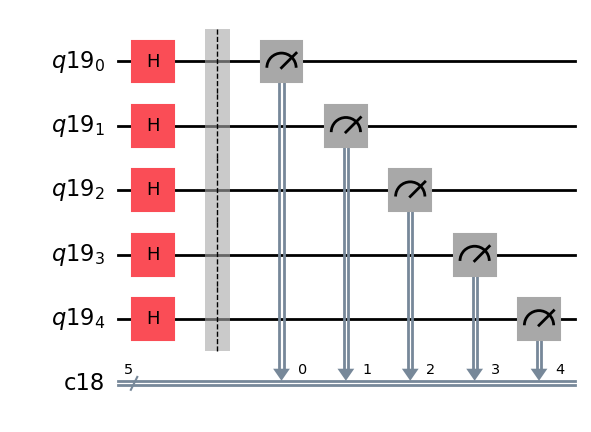

In [94]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

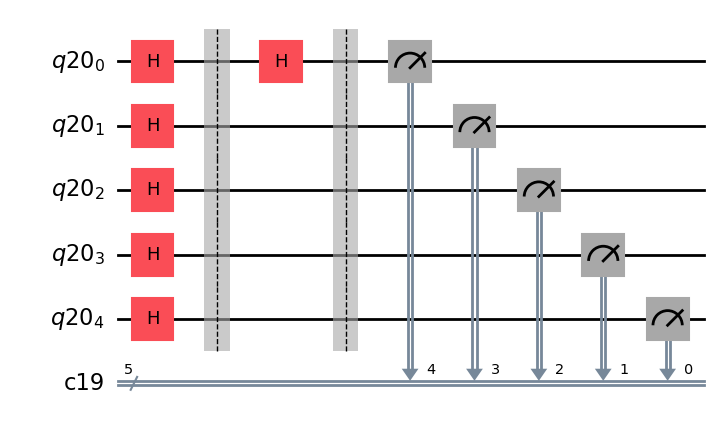

In [95]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

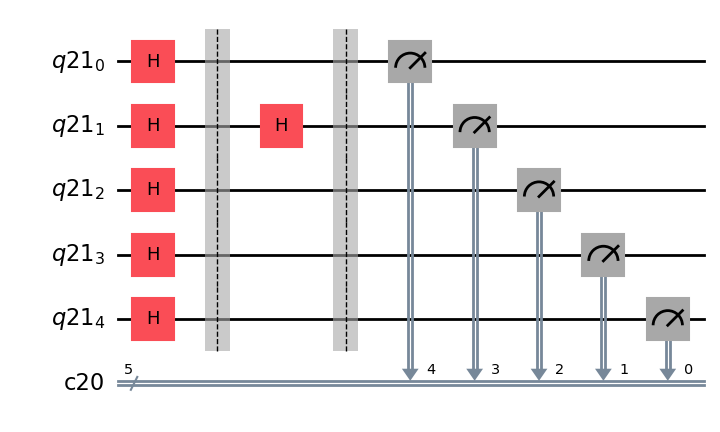

In [96]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

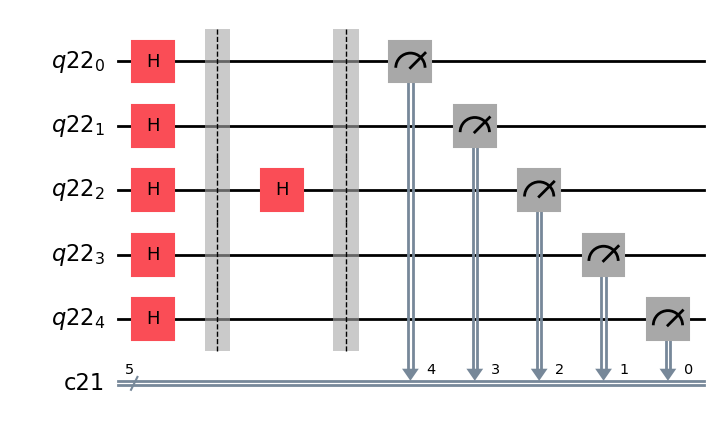

In [97]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

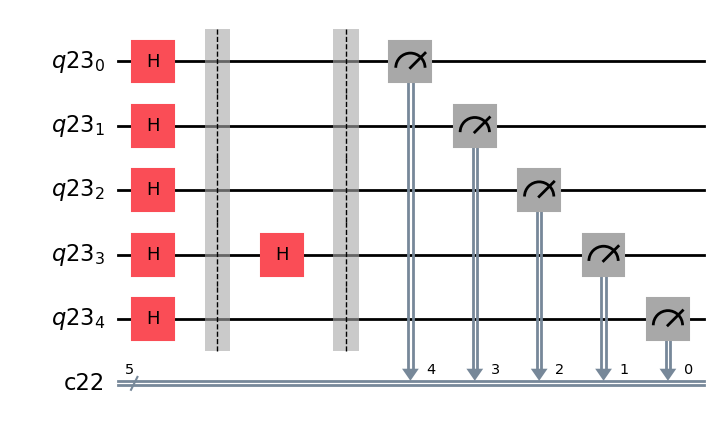

In [98]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

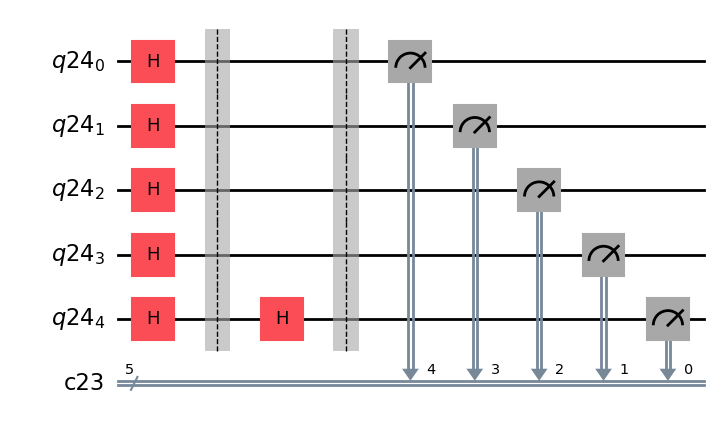

In [99]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [100]:
noise_model = NoiseModel()

# Example error probabilities
p_bit = 0.01

bit1 = pauli_error([('X', p_bit), ('I', 1 - p_bit)])
bit2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for NN

In [107]:
prob_string_zz = {18: 0.032875, 10: 0.02875, 26: 0.03225, 17: 0.030625, 9: 0.031875, 5: 0.032375, 31: 0.033, 27: 0.032375, 16: 0.036375, 7: 0.03075, 3: 0.030125, 21: 0.032, 28: 0.029875, 11: 0.032, 1: 0.03075, 6: 0.02875, 2: 0.03325, 15: 0.03675, 22: 0.029625, 13: 0.032375, 8: 0.03125, 12: 0.026875, 24: 0.0295, 29: 0.03075, 19: 0.029875, 23: 0.028875, 20: 0.03125, 4: 0.030375, 30: 0.032, 14: 0.0335, 0: 0.028, 25: 0.031}
prob_string_x0 = {15: 0.065, 4: 0.06275, 1: 0.067, 13: 0.0585, 6: 0.05925, 8: 0.063375, 12: 0.0595, 2: 0.063125, 0: 0.05875, 10: 0.06075, 14: 0.07025, 9: 0.06275, 5: 0.06325, 11: 0.064625, 3: 0.0605, 7: 0.060625, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x1 = {4: 0.06275, 22: 0.07025, 6: 0.05925, 20: 0.0595, 3: 0.0605, 7: 0.060625, 16: 0.063375, 2: 0.063125, 0: 0.05875, 23: 0.065, 1: 0.067, 21: 0.0585, 18: 0.06075, 19: 0.064625, 17: 0.06275, 5: 0.06325, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x2 = {8: 0.06275, 10: 0.05925, 25: 0.0585, 27: 0.065, 16: 0.063375, 2: 0.063125, 0: 0.05875, 1: 0.067, 18: 0.06075, 19: 0.064625, 17: 0.06275, 26: 0.07025, 9: 0.06325, 24: 0.0595, 3: 0.0605, 11: 0.060625, 4: 0, 5: 0, 6: 0, 7: 0, 12: 0, 13: 0, 14: 0, 15: 0, 20: 0, 21: 0, 22: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x3 = {29: 0.065, 8: 0.06275, 12: 0.05925, 25: 0.0585, 16: 0.063375, 4: 0.063125, 20: 0.06075, 1: 0.067, 28: 0.07025, 21: 0.064625, 0: 0.05875, 24: 0.0595, 17: 0.06275, 9: 0.06325, 5: 0.0605, 13: 0.060625, 2: 0, 3: 0, 6: 0, 7: 0, 10: 0, 11: 0, 14: 0, 15: 0, 18: 0, 19: 0, 22: 0, 23: 0, 26: 0, 27: 0, 30: 0, 31: 0}
prob_string_x4 = {30: 0.065, 2: 0.067, 0: 0.05875, 12: 0.05925, 26: 0.0585, 16: 0.063375, 4: 0.063125, 20: 0.06075, 18: 0.06275, 28: 0.07025, 22: 0.064625, 10: 0.06325, 24: 0.0595, 8: 0.06275, 6: 0.0605, 14: 0.060625, 1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0, 15: 0, 17: 0, 19: 0, 21: 0, 23: 0, 25: 0, 27: 0, 29: 0, 31: 0}

In [108]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [109]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [110]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [111]:
def Z0Z1(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [112]:
def X0(params_nn):
  prob_string = prob_string_x0
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn):
  prob_string = prob_string_x1
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn):
  prob_string = prob_string_x2
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn):
  prob_string = prob_string_x3
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn):
  prob_string = prob_string_x4
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [113]:
def norm(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [114]:
def cost_func_vqnhe(params_nn):
  expval = 0
  expval = expval + Z0Z1(params_nn)
  expval = expval + Z1Z2(params_nn)
  expval = expval + Z2Z3(params_nn)
  expval = expval + Z3Z4(params_nn)

  expval = expval - X0(params_nn)
  expval = expval - X1(params_nn)
  expval = expval - X2(params_nn)
  expval = expval - X3(params_nn)
  expval = expval - X4(params_nn)

  expval = expval / norm(params_nn)

  return expval

In [115]:
def build_callback_vqnhe(callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Repeat Optimizing Parameters in NN for 10 times

np.random.seed(k)

k 0~10

In [ ]:
local_minimum_list = []

for k in range(10):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(callback_dict)

  options = dict()
  options["maxiter"] = 1000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
## NN optimized parameter

op_param_nn = np.array([-9.22180949e-02,  9.56885647e-01,  6.88698189e-01, -9.60894992e-01,
       -5.16257191e-01,  1.12880484e+00, -4.90604068e-02, -4.79754918e-01,
       -5.70896439e-01, -7.43752046e-01,  3.81646315e-01, -2.66619155e-02,
       -5.26172704e-01, -9.88075450e-01, -1.54335683e-01, -8.64186812e-01,
        9.06271758e-01, -3.16026531e-01,  8.83174900e-01, -1.65482234e-02,
        1.84332356e-02, -1.05145855e+00, -3.17342457e-01, -4.59622683e-02,
        3.30221379e-01, -3.49445594e-01,  4.65678248e-01,  3.20867814e-01,
       -6.28029474e-01, -3.18359520e-01,  6.15487808e-01, -1.20731615e+00,
        6.42106145e-01, -8.02666873e-01,  1.44691071e-01,  5.45375755e-01,
       -3.95310145e-01,  9.19024433e-01, -7.47347185e-02, -4.73706739e-01,
       -2.51195675e-01,  5.50422543e-01, -4.49306421e-01, -8.96762892e-01,
       -4.20794800e-01,  9.80758031e-01, -1.38174234e-01, -7.10808070e-01,
        1.18253111e+00, -3.33889735e-01, -6.15897139e-01, -6.64048982e-01,
       -7.28739724e-01, -6.03160498e-01,  1.01867536e+00, -5.06708336e-01,
       -4.89016302e-01, -1.36992317e-02, -8.77563696e-02,  5.57113916e-01,
        3.03116591e-01,  4.63142638e-01, -6.94176387e-01, -4.15332416e-01,
       -7.59305513e-01, -4.87878088e-01, -2.22836223e-01, -1.23182991e-02,
        7.14205287e-01, -8.83398592e-01, -4.69467370e-01, -9.29811275e-01,
        6.91020972e-02,  1.11613177e-01,  3.02827819e-01, -5.79208535e-01,
        1.98860635e-01, -7.62260829e-02, -8.36139520e-01,  2.27807426e-01,
       -5.42964875e-01, -9.27447736e-01,  9.31873136e-01, -8.58550512e-01,
        4.46932030e-01,  5.25984722e-03, -8.11053406e-01,  4.78987087e-02,
       -1.31564077e-01, -1.25255134e-02,  9.47669310e-01,  1.10986286e+00,
        1.39217618e-01, -3.41810275e-02,  8.19447117e-02,  4.70351225e-01,
        8.86800508e-02, -9.76291970e-01,  2.57896379e-01,  8.20610761e-01,
       -4.72047681e-01, -2.58840891e-01, -8.18213423e-01,  6.10153049e-02,
       -5.35198665e-01, -6.67454705e-01, -6.34982081e-01, -4.83067050e-01,
       -1.01733008e+00,  2.24069423e-01,  7.17911739e-01,  6.16526338e-01,
       -3.02654741e-01, -6.58391088e-01,  4.65362242e-01,  3.50612202e-01,
        1.64656953e-01,  1.55752889e-01,  8.23942591e-01,  1.06504076e+00,
       -8.31181561e-01, -4.80914918e-01,  6.54741124e-01, -1.54354339e-01,
       -2.47350243e-01, -3.06137265e-01, -3.87037467e-01,  5.95402835e-01,
       -7.33831897e-01,  1.07417483e+00, -4.10711894e-01, -1.25443266e-01,
       -6.33086693e-01, -4.88599227e-01,  9.13924960e-01, -5.11008820e-02,
       -7.01271776e-01,  1.23035910e-03,  2.39934649e-01,  7.51526846e-01,
       -4.09601008e-01,  9.75551234e-01, -4.91640117e-01, -4.18717604e-01,
       -2.20061126e-01, -4.61178717e-01,  2.43245804e-01, -6.54922182e-01,
       -8.81621146e-02, -1.59459827e-01,  4.38921044e-01, -4.62907292e-01,
       -7.41747631e-01, -1.09264849e+00,  9.75015218e-01, -5.77892681e-02,
        4.02304891e-01,  8.70924868e-01, -5.14963856e-02,  3.63069387e-01,
        2.67469380e-01,  8.56785446e-01,  5.99962463e-01, -9.14557184e-02,
       -1.08622565e-01, -5.43918737e-01,  1.43063927e-01, -9.03393154e-01,
        1.20041032e-01, -8.34833766e-01, -5.38048246e-02,  8.20040185e-02,
        5.19980784e-01, -3.19074819e-01,  2.31399123e-01,  7.93074115e-02,
       -4.84724980e-01, -3.75988747e-01, -1.36844345e-01, -3.21713575e-01,
        1.30758822e-02, -1.32368049e-01,  5.55381098e-01, -2.05028630e-01,
       -2.30709494e-01,  9.59364971e-01, -1.44511555e+00, -6.65969972e-01,
        1.96598417e-02, -3.47792229e-01,  1.25951418e-01,  3.58432995e-01,
       -1.79912239e-01, -5.67448137e-01, -7.06266508e-01, -4.90590250e-01,
       -2.08168009e-01, -8.63035297e-01,  5.93401268e-01, -8.73833384e-01,
       -9.25408911e-01, -6.01411438e-01, -5.55439529e-01, -4.70688097e-01,
       -9.70981010e-01, -2.29512968e-01,  3.65430606e-01, -8.03301433e-01,
        3.88788201e-01, -8.16259742e-01,  9.43835090e-01, -3.24557772e-02,
        1.82019099e-01, -1.69821113e-01,  4.80533001e-01, -3.55982320e-01,
       -4.43132716e-01, -7.32656893e-01,  6.14692427e-01, -7.15502702e-01,
       -8.08372249e-01,  3.52333729e-01,  8.98695242e-01, -8.02786590e-01,
       -4.28980146e-01, -7.39631119e-01, -2.81784463e-01, -8.87080486e-02,
        6.59658969e-01, -3.12894721e-01,  5.46293604e-01, -1.41913759e-01,
       -5.78694042e-02, -1.68501784e-02, -5.30647389e-01, -4.03222415e-01,
        1.08702860e+00, -7.37198015e-01,  2.32178769e-01, -7.09824417e-01,
        2.45352759e-04, -8.84002406e-01, -9.38165250e-01, -4.04995087e-01,
       -1.64400926e-01,  3.61014677e-01, -1.51523761e-01,  7.02847841e-01,
       -1.29521502e-01,  6.17379612e-01, -2.00426707e-01,  9.68866895e-01,
        4.37013555e-01, -6.06940034e-01, -4.88437938e-01, -1.66566116e-01,
        5.54790155e-01, -6.12397627e-01,  5.10995192e-01,  7.46487106e-01,
       -7.26298665e-01, -2.63988418e-01,  8.97411010e-01,  7.25906575e-01,
        8.87636443e-01,  9.19887419e-01, -2.83598814e-01,  2.54789060e-01,
       -2.45922503e-01,  4.92943123e-01, -3.10910237e+00])

## Plot Result of VQNHE in Noisy Simulator (Bit Flip Channel, 0.01)

Neural Net Lowest Energy Configurations for 10 times

[-6.026677749855398,
 -6.026677749976061,
 -6.026677748494037,
 -6.024063072414603,
 -6.026677749556434,
 -6.008426000579483,
 -6.026677749815028,
 -6.026677750075579,
 -6.026677750116603,
 -6.026677750117541]

VQNHE Lowest Energy Configuration for 100 times

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [ ]:
nn_minimum_list = np.array([-6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02544544, -6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02667418])

In [ ]:
vqnhe_minimum_list = np.array([-6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02544544, -6.02667418, -6.02667418, -6.02667418, -6.02667418, -6.02667418])

In [ ]:
vqe_minimum_list = np.array([-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667,
-5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285,
-5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605,
-5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143,
-5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138,
-5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454,
-5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845,
-5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557,
-5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463,
-5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585,
-5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668,
-5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428,
-5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  ,
-5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653,
-5.89196071, -5.89641764, -5.88954192, -5.89643247])

In [ ]:
mean_nn = np.mean(nn_minimum_list)
var_nn = np.var(nn_minimum_list)
max_nn = np.max(nn_minimum_list)
min_nn = np.min(nn_minimum_list)

print("mean : {0}".format(mean_nn))
print("variance : {0}".format(var_nn))
print("maximum : {0}".format(max_nn))
print("minimum : {0}".format(min_nn))
print()
print(nn_minimum_list)

mean : -6.026551306
variance : 1.3588217888384173e-07
maximum : -6.02544544
minimum : -6.02667418

[-6.02667418 -6.02667418 -6.02667418 -6.02667418 -6.02544544 -6.02667418
 -6.02667418 -6.02667418 -6.02667418 -6.02667418]


In [ ]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -6.026551306
variance : 1.3588217888384173e-07
maximum : -6.02544544
minimum : -6.02667418

[-6.02667418 -6.02667418 -6.02667418 -6.02667418 -6.02544544 -6.02667418
 -6.02667418 -6.02667418 -6.02667418 -6.02667418]


In [ ]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577

# NN in by Noisy Simulator (Depolarization Channel, 0.01)

1. Only Apply Hadamard Gate for (P)QC

2. Measure each probability of bitstring and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [134]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

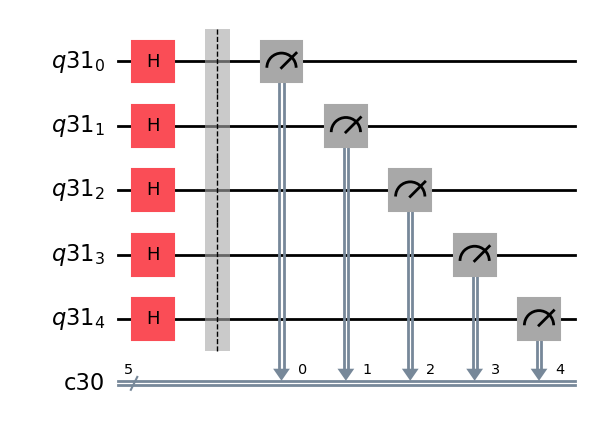

In [135]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

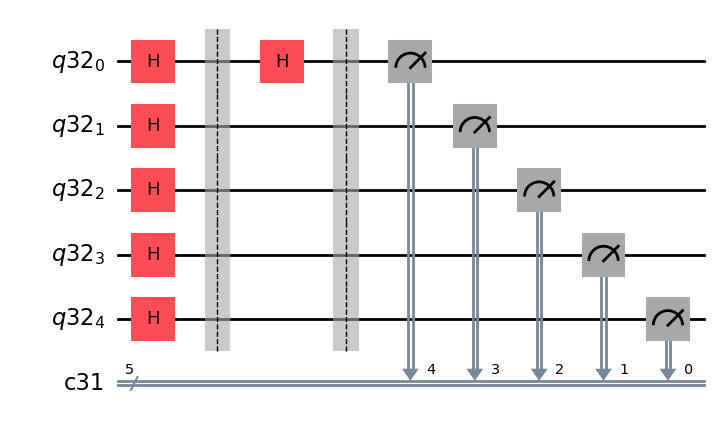

In [136]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

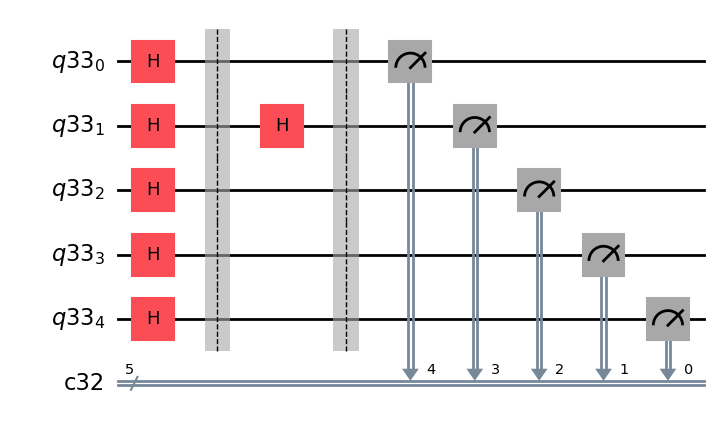

In [137]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

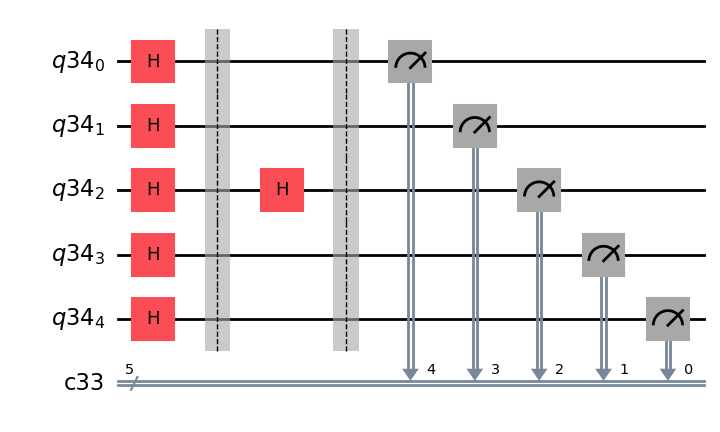

In [138]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

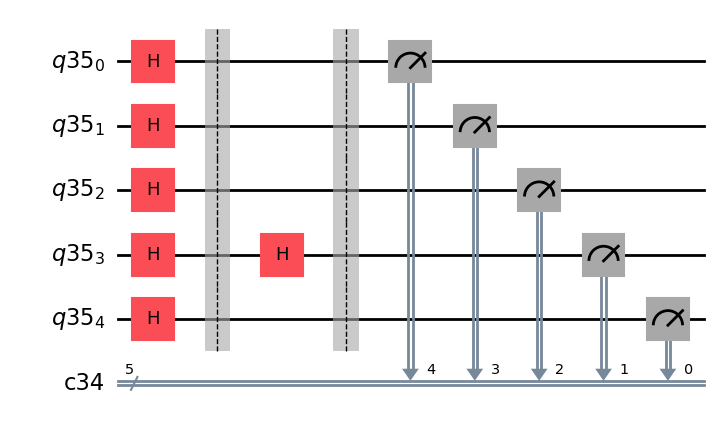

In [139]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

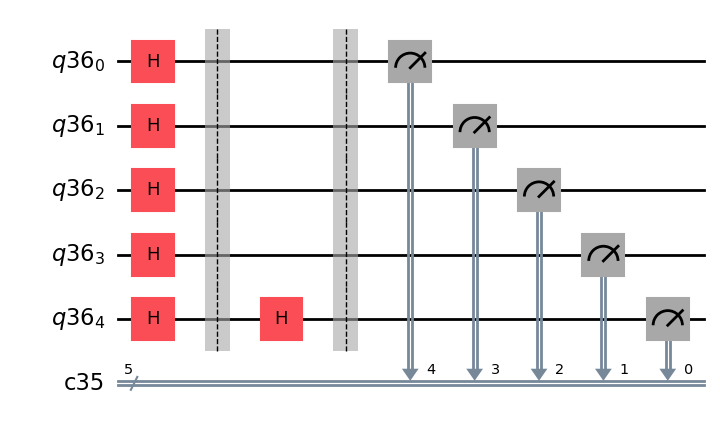

In [140]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [141]:
noise_model = NoiseModel()

# Example error probabilities
u_depolarizing_prob = 0.01
cx_depolarizing_prob = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(depolarizing_error(u_depolarizing_prob, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for VQNHE

In [142]:
job = sampler.run(ansatz_x4, shots=8000, seed=1).result()
prob_string = job.quasi_dists[0]

for i in range(32):
  if not (i in prob_string):  prob_string[i] = 0

prob_string

{30: 0.065, 2: 0.067, 0: 0.05875, 12: 0.05925, 26: 0.0585, 16: 0.063375, 4: 0.063125, 20: 0.06075, 18: 0.06275, 28: 0.07025, 22: 0.064625, 10: 0.06325, 24: 0.0595, 8: 0.06275, 6: 0.0605, 14: 0.060625, 1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0, 15: 0, 17: 0, 19: 0, 21: 0, 23: 0, 25: 0, 27: 0, 29: 0, 31: 0}

In [143]:
prob_string_zz = {18: 0.032875, 10: 0.02875, 26: 0.03225, 17: 0.030625, 9: 0.031875, 5: 0.032375, 31: 0.033, 27: 0.032375, 16: 0.036375, 7: 0.03075, 3: 0.030125, 21: 0.032, 28: 0.029875, 11: 0.032, 1: 0.03075, 6: 0.02875, 2: 0.03325, 15: 0.03675, 22: 0.029625, 13: 0.032375, 8: 0.03125, 12: 0.026875, 24: 0.0295, 29: 0.03075, 19: 0.029875, 23: 0.028875, 20: 0.03125, 4: 0.030375, 30: 0.032, 14: 0.0335, 0: 0.028, 25: 0.031}
prob_string_x0 = {15: 0.065, 4: 0.06275, 1: 0.067, 13: 0.0585, 6: 0.05925, 8: 0.063375, 12: 0.0595, 2: 0.063125, 0: 0.05875, 10: 0.06075, 14: 0.07025, 9: 0.06275, 5: 0.06325, 11: 0.064625, 3: 0.0605, 7: 0.060625, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x1 = {4: 0.06275, 22: 0.07025, 6: 0.05925, 20: 0.0595, 3: 0.0605, 7: 0.060625, 16: 0.063375, 2: 0.063125, 0: 0.05875, 23: 0.065, 1: 0.067, 21: 0.0585, 18: 0.06075, 19: 0.064625, 17: 0.06275, 5: 0.06325, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x2 = {8: 0.06275, 10: 0.05925, 25: 0.0585, 27: 0.065, 16: 0.063375, 2: 0.063125, 0: 0.05875, 1: 0.067, 18: 0.06075, 19: 0.064625, 17: 0.06275, 26: 0.07025, 9: 0.06325, 24: 0.0595, 3: 0.0605, 11: 0.060625, 4: 0, 5: 0, 6: 0, 7: 0, 12: 0, 13: 0, 14: 0, 15: 0, 20: 0, 21: 0, 22: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0}
prob_string_x3 = {29: 0.065, 8: 0.06275, 12: 0.05925, 25: 0.0585, 16: 0.063375, 4: 0.063125, 20: 0.06075, 1: 0.067, 28: 0.07025, 21: 0.064625, 0: 0.05875, 24: 0.0595, 17: 0.06275, 9: 0.06325, 5: 0.0605, 13: 0.060625, 2: 0, 3: 0, 6: 0, 7: 0, 10: 0, 11: 0, 14: 0, 15: 0, 18: 0, 19: 0, 22: 0, 23: 0, 26: 0, 27: 0, 30: 0, 31: 0}
prob_string_x4 = {30: 0.065, 2: 0.067, 0: 0.05875, 12: 0.05925, 26: 0.0585, 16: 0.063375, 4: 0.063125, 20: 0.06075, 18: 0.06275, 28: 0.07025, 22: 0.064625, 10: 0.06325, 24: 0.0595, 8: 0.06275, 6: 0.0605, 14: 0.060625, 1: 0, 3: 0, 5: 0, 7: 0, 9: 0, 11: 0, 13: 0, 15: 0, 17: 0, 19: 0, 21: 0, 23: 0, 25: 0, 27: 0, 29: 0, 31: 0}

In [144]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [145]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [146]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [147]:
def Z0Z1(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [148]:
def X0(params_nn):
  prob_string = prob_string_x0
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn):
  prob_string = prob_string_x1
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn):
  prob_string = prob_string_x2
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn):
  prob_string = prob_string_x3
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn):
  prob_string = prob_string_x4
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [149]:
def norm(params_nn):
  prob_string = prob_string_zz
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [150]:
def cost_func_vqnhe(params_nn):
  expval = 0
  expval = expval + Z0Z1(params_nn)
  expval = expval + Z1Z2(params_nn)
  expval = expval + Z2Z3(params_nn)
  expval = expval + Z3Z4(params_nn)

  expval = expval - X0(params_nn)
  expval = expval - X1(params_nn)
  expval = expval - X2(params_nn)
  expval = expval - X3(params_nn)
  expval = expval - X4(params_nn)

  expval = expval / norm(params_nn)

  return expval

In [151]:
def build_callback_vqnhe(callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Repeat Optimizing Parameters in NN for 10 times

np.random.seed(k)

k 0~10

In [ ]:
local_minimum_list = []

for k in range(15):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(callback_dict)

  options = dict()
  options["maxiter"] = 1000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
## NN optimized parameter

op_param_nn = np.array([ 0.44855611, -0.75890078,  0.10780264,  0.80945932, -0.08550565,
       -0.32392527, -0.6578295 ,  0.64794882, -0.66177833, -0.82332037,
        0.49890282,  1.18849393, -1.1529314 , -0.26321966,  0.59057445,
        0.50182816,  0.45259964, -0.5938356 ,  1.05485963, -0.09867208,
        0.4459861 , -0.7321852 ,  0.03100863,  0.28597402, -0.2501669 ,
       -0.11405975,  0.20824048,  0.06131092, -0.29529734,  0.42546156,
        0.17723267,  0.09052077,  1.0195445 , -0.67455141, -0.73516063,
       -0.31420417, -0.93285587,  0.47636501, -0.91077941,  0.3733171 ,
       -0.12298936,  0.23273768, -1.12616776,  0.87281213, -0.6001478 ,
        0.43518111, -0.24844476,  1.07755124, -0.34822435, -0.33200857,
       -0.23324713, -0.81848441,  0.59164094, -0.8414328 , -0.24123345,
        0.86154122,  0.82887775, -0.01499076,  0.62623094, -0.56882298,
        0.23100156,  0.86943054,  0.11150132,  0.21855232, -1.0128773 ,
       -0.32192472, -0.90902885, -0.43085527, -0.14962373,  0.4397629 ,
       -0.93070006, -0.2280482 , -0.54796086,  0.49610652, -0.29891461,
       -0.93355448,  0.45606337,  0.49277433,  0.85308394, -0.34862393,
        0.21115513,  0.02693325,  0.19338229, -0.47634375, -0.39825738,
       -0.94938252, -0.39387488, -0.51584825,  0.11421632,  0.13101404,
        0.32992805, -0.46856463, -1.10091028,  0.81422806, -0.19027311,
       -0.18797532,  0.78978617, -0.11850603, -0.55434998,  0.14470877,
        0.15664052,  0.74070601, -0.68950033, -0.19347522,  0.60701607,
        0.28424621,  0.15348443, -1.10287577, -0.31368632,  0.14915425,
       -0.4005875 ,  0.02466831,  0.2690946 , -0.84026541, -0.89904466,
       -0.33193344, -0.78430919, -0.64219438,  0.67568791, -0.27208082,
       -0.6188896 ,  0.50499234, -0.75856439,  0.43985834, -0.07445244,
        0.13797141, -0.70721004, -0.63192362,  0.36066031, -0.90730423,
       -0.33599917, -0.0385608 , -1.01011724, -0.41752991,  0.69947304,
        0.83466865, -0.12959654,  0.11292173, -0.93883396,  0.852418  ,
        0.23987932,  0.58351399,  0.20993137,  0.66027527,  0.19663634,
        0.39137576, -0.72098526, -0.16043874,  0.2837504 , -0.68547572,
       -0.54939942, -0.66791697, -0.03462852,  0.47478518, -0.92327919,
        0.55822618,  0.29116264,  0.19382843, -0.55317833, -0.28100443,
       -0.38014152, -0.92488465, -0.96234216, -0.09112866,  0.48491162,
        0.05470791, -0.23455807, -0.6638544 ,  0.69244508,  0.14330681,
        0.51991958,  0.6939694 ,  0.26174538,  0.57164123,  0.22938716,
       -0.9622608 ,  0.47411758, -0.65462584, -0.05573361, -0.01720971,
       -0.03361561,  0.68037307, -0.62731803, -0.97073025,  0.69712114,
        0.5273171 , -0.09910576, -0.17255226, -0.76654098, -0.32645198,
       -0.80771651,  0.42340914, -0.84582919, -0.58774804,  0.14755246,
       -0.40653348,  0.29850905,  0.62150886, -0.29757299, -0.8226143 ,
        0.26614048,  0.64358462,  0.00291165,  0.7405856 , -0.25702956,
       -0.39946386,  0.81993711,  0.39489789,  0.06980119,  0.26880764,
       -0.64533355,  0.7914179 ,  0.71827332, -0.47555702,  0.70468717,
       -0.57940905, -0.98948333, -0.89989993, -0.54284561, -0.95228748,
       -0.50994645,  0.70200649, -0.17885309, -0.74992541,  0.61978333,
       -0.38985381, -1.21314576,  0.49396586, -0.45141036, -0.02940453,
        0.06778545,  0.48934326,  0.77816177,  0.37280214,  0.16880743,
       -0.45309255, -0.66004155,  0.04676844,  0.08830501,  0.83135715,
       -0.36415261, -0.20711624,  0.57545903, -0.60779529, -0.606471  ,
        0.66706845,  0.05639343, -0.87306544,  0.97255158, -0.37489998,
       -0.12500851, -0.55757425,  0.59817407,  0.25506421,  0.58528208,
       -0.42936399, -0.49144846,  0.2417976 ,  0.67274824,  0.2867868 ,
       -0.38389273, -0.74101921, -0.30204202,  0.95283403,  0.371806  ,
       -0.30179996, -0.85568383,  0.83057125,  0.41893217,  0.64624123,
        2.30752495])

## Plot Result of VQNHE in Noiseless Simulator

Neural Net Lowest Energy Configurations for 10 times

[-6.026677749855398,
 -6.026677749976061,
 -6.026677748494037,
 -6.024063072414603,
 -6.026677749556434,
 -6.008426000579483,
 -6.026677749815028,
 -6.026677750075579,
 -6.026677750116603,
 -6.026677750117541]

VQNHE Lowest Energy Configuration for 100 times

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [155]:
nn_minimum_list = np.array([-6.026677749855398, -6.026677749976061, -6.026677748494037, -6.024063072414603, -6.026677749556434, -6.008426000579483, -6.026677749815028, -6.026677750075579, -6.026677750116603, -6.026677750117541])

In [156]:
vqnhe_minimum_list = np.array([-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368])

In [157]:
vqe_minimum_list = np.array([-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116, -5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 , -5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521 , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418 , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247])

In [158]:
mean_nn = np.mean(nn_minimum_list)
var_nn = np.var(nn_minimum_list)
max_nn = np.max(nn_minimum_list)
min_nn = np.min(nn_minimum_list)

print("mean : {0}".format(mean_nn))
print("variance : {0}".format(var_nn))
print("maximum : {0}".format(max_nn))
print("minimum : {0}".format(min_nn))
print()
print(nn_minimum_list)

mean : -6.024591107100077
variance : 2.9642210986691072e-05
maximum : -6.008426000579483
minimum : -6.026677750117541

[-6.02667775 -6.02667775 -6.02667775 -6.02406307 -6.02667775 -6.008426
 -6.02667775 -6.02667775 -6.02667775 -6.02667775]


In [159]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.878570821800002
variance : 1.4331701778902295
maximum : 6.02667372
minimum : -6.026674

[-6.02667373 -6.02667373 -6.02667368 -6.02667354 -5.8987224  -5.97700928
 -5.96536259 -6.02667368 -6.02667371 -5.94009695 -6.02667371 -6.02628084
 -6.02667371 -5.89945393 -6.02667371 -5.9583359  -6.02667352 -6.02667373
 -6.02667368 -5.9294343  -5.94016942 -6.0266737  -6.02667358 -6.02667369
 -5.97782861 -6.0266737  -6.02667319 -5.97782869 -5.97782861 -5.97782857
 -6.02667363 -6.02667367 -5.94801533 -5.97500441 -6.02667365 -6.02667369
 -6.02659477 -6.01371031 -5.97701072 -5.89828085 -5.94063178 -5.94017144
 -6.0266737  -5.96536198 -6.02667369 -6.02642066 -6.02262504 -5.98140869
 -6.02609303 -6.02667364 -5.947205   -6.022831   -6.026674   -6.026101
 -5.96977    -6.02586    -6.02667367 -6.02113763 -6.0266737  -6.0266737
 -6.02667366 -6.02667368 -5.97976822 -5.89828149 -6.02158803 -6.02667372
 -6.02034773 -6.02288384 -6.02152311 -6.02667373 -5.98259114 -6.02667355
 -6.02667366 -6.02627895 -6.0

In [160]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577